In [2]:
# Step 1: Mount Google Drive to access our files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 2: Install the libraries we are going to use
# OpenCV is for image and video processing.
# Ultralytics gives us access to the YOLO model to detect players.
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

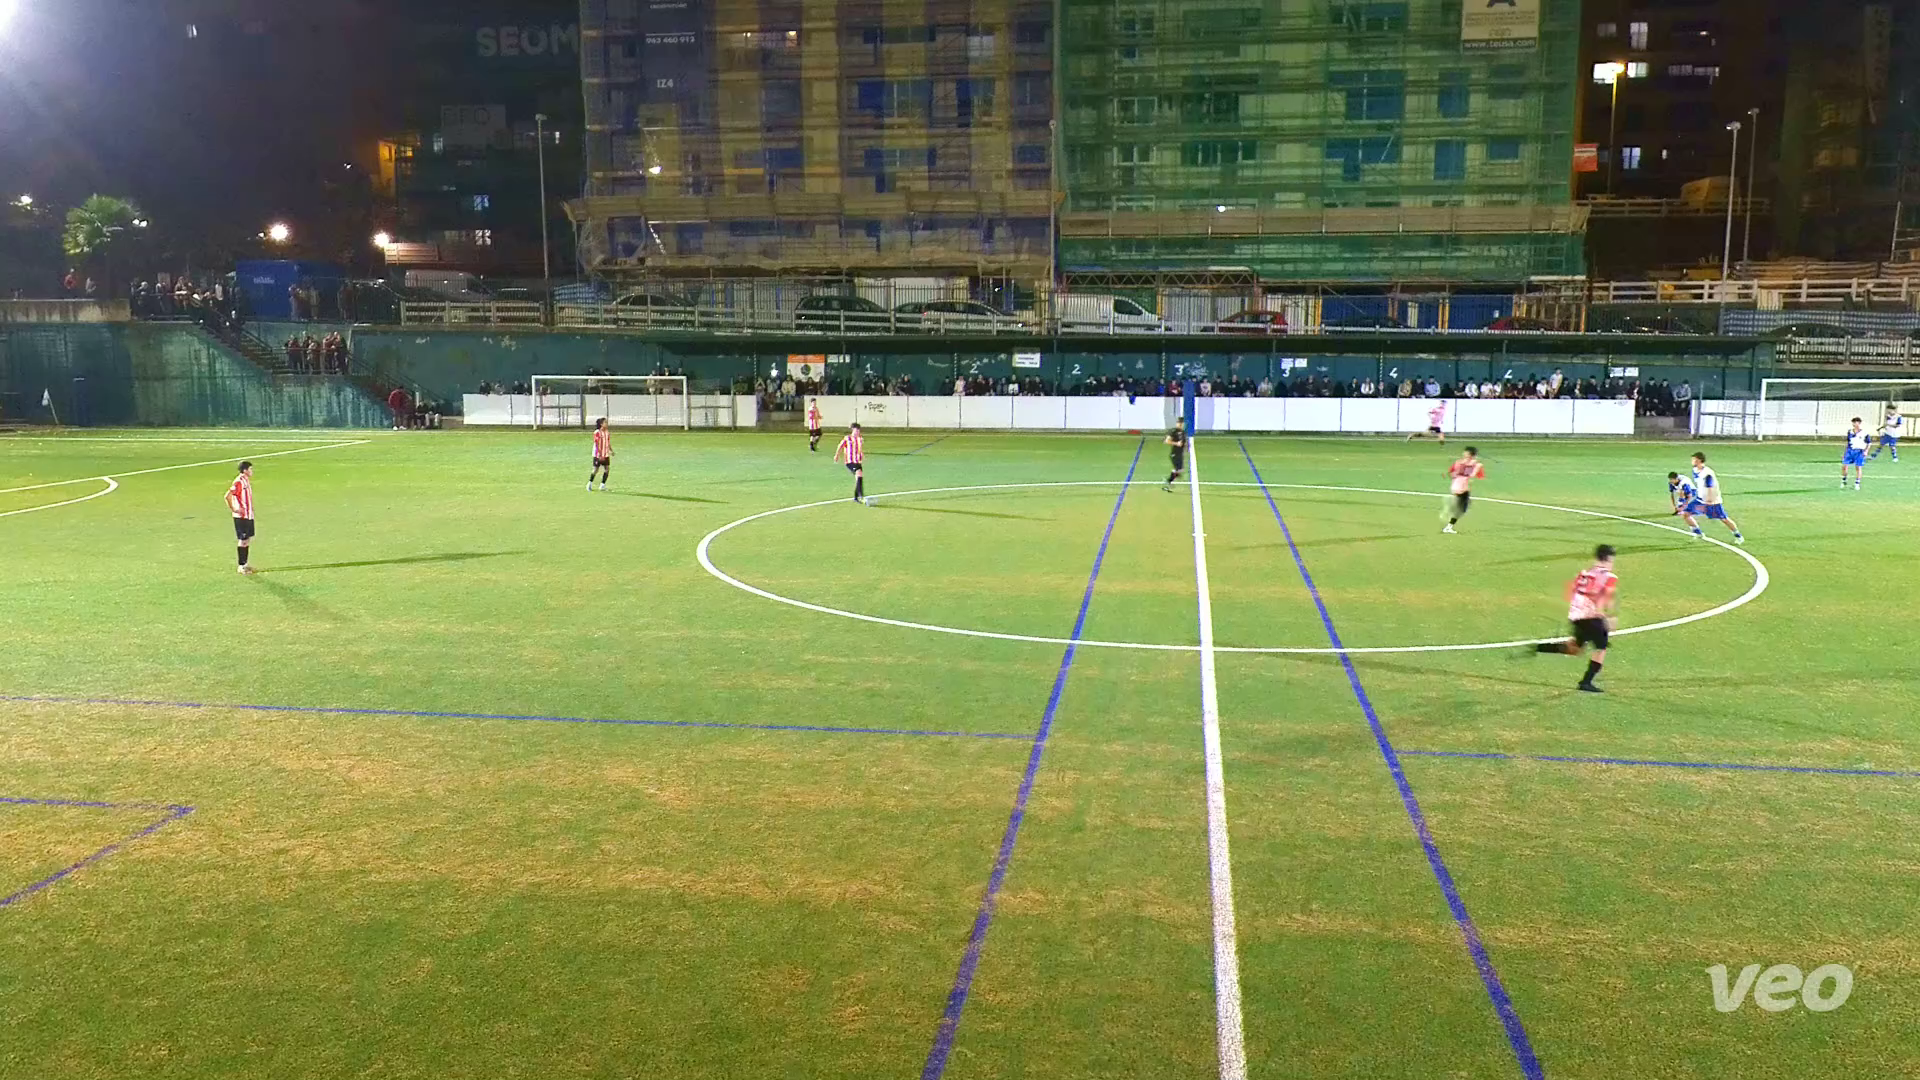

In [3]:
# Step 3: Load and test our video
import cv2
from google.colab.patches import cv2_imshow # We use this in Colab instead of cv2.imshow

# IMPORTANT: Paste here the path to your video that you copied in the previous step.
# Make sure the path is inside quotation marks.
video_path = "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/juv-primera-vs-pasaia-2024-11-23.mp4"


# === Load the video ===
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cv2_imshow(frame)
cap.release()

In [5]:
import os

cap = cv2.VideoCapture(video_path)
output_folder = "/content/frames"
os.makedirs(output_folder, exist_ok=True)
extract_every_seconds = 0.5  # You can change this to 0.5 or 2, etc.

fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps * extract_every_seconds)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps

print(f"Video FPS: {fps}")
print(f"Total frames: {frame_count}")
print(f"Video duration (s): {duration:.2f}")
print(f"Extracting 1 frame every {extract_every_seconds} second(s)")

# === Extract and save frames ===
frame_number = 0
saved_frames = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_number % frame_interval == 0:
        frame_filename = os.path.join(output_folder, f"frame_{frame_number:06d}.jpg")
        cv2.imwrite(frame_filename, frame)
        saved_frames += 1

    frame_number += 1

cap.release()
print(f"Extraction complete. {saved_frames} frames saved to '{output_folder}'")

Video FPS: 29.97003059754367
Total frames: 190849
Video duration (s): 6367.99
Extracting 1 frame every 0.5 second(s)
Extraction complete. 13633 frames saved to '/content/frames'


In [6]:
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/frames"
!cp /content/frames/*.jpg "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/frames/"

In [4]:
# Install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 17516 (delta 8), reused 0 (delta 0), pack-reused 17494 (from 3)
Receiving objects: 100% (17516/17516), 16.62 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (12004/12004), done.
/content/yolov5


In [5]:
import torch
import os
from matplotlib import pyplot as plt
from PIL import Image

# Load YOLOv5s model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # Loads pre-trained YOLOv5s
model.classes = [0]  # Class 0 = person

# Path to your frames
frames_folder = "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/frames"
frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')])

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-8-1 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 74.1MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [6]:
!git clone https://github.com/abewley/sort.git

Cloning into 'sort'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 208 (delta 45), reused 40 (delta 40), pack-reused 159 (from 1)
Receiving objects: 100% (208/208), 1.20 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [19]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=4bbe9ba92982436f7e5a7faf6603f1f9543d1eaf626871cd6ecd2d3d4a3cbbf5
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [17]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/futbol_analysis')

In [20]:
# === Safe imports for headless mode ===
import os
import cv2
import torch
import pandas as pd
import numpy as np
import my_sort
print(my_sort.__file__)

# === Configuración ===
frames_folder = "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/frames"
output_video_path = "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/clip_tracking.mp4"
output_csv_path = "/content/drive/MyDrive/Colab Notebooks/futbol_analysis/tracking_data.csv"
clip_duration_seconds = 8
frame_rate = 30  # Ajusta si el vídeo original tiene otro frame rate
max_frames = int(clip_duration_seconds * frame_rate)

# === Cargar modelo YOLOv5 (solo detecta personas) ===
device = '0' if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', device=device)
model.classes = [0]  # Clase 0 = persona

# === Inicializar el tracker SORT ===
tracker = my_sort.Sort()

# === Leer y ordenar los frames ===
frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')])[:max_frames]

if not frame_files:
    print("❌ No se encontraron frames en la carpeta indicada.")
else:
    # Preparar el primer frame para extraer tamaño
    first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
    h, w, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (w, h))

    all_tracking_data = []  # Para guardar datos del CSV

    # === Procesar cada frame ===
    for frame_idx, filename in enumerate(frame_files):
        frame_path = os.path.join(frames_folder, filename)
        frame = cv2.imread(frame_path)

        # Inferencia YOLO
        results = model(frame)
        detections = results.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2, conf, class]

        # Preparar detecciones para SORT
        dets_for_sort = []
        for det in detections:
            if int(det[5]) == 0:  # persona
                x1, y1, x2, y2, conf = det[:5]
                dets_for_sort.append([x1, y1, x2, y2, conf])
        dets_for_sort = np.array(dets_for_sort) if dets_for_sort else np.empty((0, 5))

        # Actualizar tracker
        tracked_objects = tracker.update(dets_for_sort)

        # Dibujar cajas y guardar info
        for track in tracked_objects:
            x1, y1, x2, y2, track_id = track.astype(int)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            all_tracking_data.append({
                "frame": frame_idx,
                "track_id": int(track_id),
                "x_min": int(x1),
                "y_min": int(y1),
                "x_max": int(x2),
                "y_max": int(y2)
            })

        # Escribir frame al vídeo
        video_out.write(frame)

    # Guardar resultados
    video_out.release()
    pd.DataFrame(all_tracking_data).to_csv(output_csv_path, index=False)

    print(f"✅ Vídeo guardado en: {output_video_path}")
    print(f"✅ CSV guardado en: {output_csv_path}")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-1 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 


/content/drive/MyDrive/Colab Notebooks/futbol_analysis/my_sort.py


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root

✅ Vídeo guardado en: /content/drive/MyDrive/Colab Notebooks/futbol_analysis/clip_tracking.mp4
✅ CSV guardado en: /content/drive/MyDrive/Colab Notebooks/futbol_analysis/tracking_data.csv


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
